#  기계학습 실습 Week 2b (모델 학습)

2024.9.11.

서강대 경제학과 양현주 (hyang@sogang.ac.kr)<br><br>

FASTAI를 활용하여 이미지 분류 딥러닝 실습 - 이번엔 로컬 컴퓨터의 데이터로 하기 (multi-class problem)<br><br>

Image data source: 조원호, 임용호, 박기호 (2019)<br> "합성곱 신경망을 이용한 딥러닝 기반의 토지피복 분류 : 한국 토지피복을 대상으로" 대한지리학회지 54(1) <br>
https://www.kci.go.kr/kciportal/ci/sereArticleSearch/ciSereArtiView.kci?sereArticleSearchBean.artiId=ART002446704 <br><br>

참조한 FastAI 코드: <br>

https://github.com/fastai/fastbook/blob/master/01_intro.ipynb <br>
https://github.com/fastai/fastbook/blob/master/02_production.ipynb <br><br>

Another useful blog link: <br>

https://towardsdatascience.com/classifying-images-of-alcoholic-beverages-with-fast-ai-34c4560b5543

다음주 목요일 퀴즈

새로운 데이터 or 클래스로 바꾸든 해서 나올 것(image classification class 이름으로 서브 폴더 만들고 ) / 오픈북 /
개/고양이 분류 , 클래스 나누기 , 데이터 전처리(today)
직접 코드와 결과물을 싸캠에 업로드

9/19 (목)

# FASTai 코드 1번 링크
non-image tasks -> image로 변환  
ex) 소리 데이터, 시계열 데이터, 매크로 detector 왼쪽, 오른쪽 마우스의 움직임을 detect
## 토지피복 논문
- 토지피복도를 나타낸 이미지를 한 번에 주고 분류하게 함
- epochs가 500번 -> training dataset만 잘 아는 쓸모없는 모델이 됨 = validation set의 accuracy 는 어느 순간부터 낮아짐 = **overfitting!!**
- normalized confusion matrix가 training set/ validation set의 accuracy를 나타내는지



# 1. Install and import libraries

In [1]:
import fastai
print(fastai.__version__)

from fastai.vision.all import *
#from fastai.text.all import *
#from fastai.collab import *
#from fastai.tabular.all import *

from matplotlib.pyplot import imshow

2.7.17


In [2]:
from google.colab import files

In [3]:
from google.colab import drive  # not necessary

# 2. Upload images to Colab

In [ ]:
"""
Alternatives for uploading files to colab (other than dropbox)

1) mount google drive using the codes below:
from google.colab import drive
drive.mount('/content/drive')

2) use dropbox link -> 대용량일 때

3) directly upload using "files" menu on the left and click "upload to session storage" -> 맥은 압축할 때 다른 파일 섞이지 않게 유의
파일별로 이미지 넣어놓고 하나의 파일로 압축

"""

In [4]:
# set the name of the folder to download images
img_folder_nm = 'new_folder'  # 이 이름은 바꿔도 됨

# set the name of the zip file to be downloaded
img_zipfile_nm = 'insight_img.zip' # 올린 파일의 이름으로 고정 -> 압축파일 이름이 다르면 바꿔줘야 함

In [ ]:
# uncomment if dropbox link is used to download file

# dropbox link for images
#dropbox_link = 'YOUR_OWN_DROPBOX_LINK'

# download dropbox link
#!wget -O {img_zipfile_nm} {dropbox_link}

In [5]:
!ls

insight_img.zip  lclu  sample_data


In [6]:
%%capture

!unzip {img_zipfile_nm} -d {img_folder_nm}

In [7]:
!ls {img_folder_nm}

insight_img  __MACOSX


# 3. Prepare images

In [8]:
# location of images
path = Path(img_folder_nm)

# get list of image files
file_names = get_image_files(path)
file_names

# (#1500) -> 파일이 1500개가 있음을 의미

(#179) [Path('new_folder/insight_img/Signed/rz_IMG_0715.jpg'),Path('new_folder/insight_img/Signed/rz_IMG_0718.jpg'),Path('new_folder/insight_img/Signed/rz_IMG_0706.jpg'),Path('new_folder/insight_img/Signed/rz_IMG_0643.jpg'),Path('new_folder/insight_img/Signed/rz_IMG_0714.jpg'),Path('new_folder/insight_img/Signed/rz_IMG_0677.jpg'),Path('new_folder/insight_img/Signed/rz_IMG_0737.jpg'),Path('new_folder/insight_img/Signed/rz_IMG_0640.jpg'),Path('new_folder/insight_img/Signed/rz_IMG_0685.jpg'),Path('new_folder/insight_img/Signed/rz_IMG_0642.jpg')...]

(800, 1200)


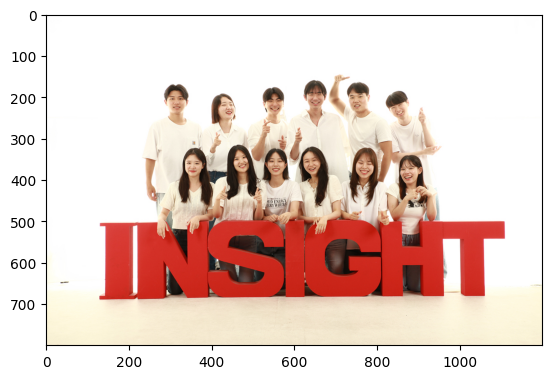

In [9]:
# show an example image

im = Image.open(file_names[0])
print(im.shape)
imshow(im)

In [10]:
# find corrupt images and unlink them

corrupt_images = verify_images(file_names)

corrupt_images.map(Path.unlink);

corrupt_images

(#0) []

In [11]:
# data block settings

image_size = 64  # 모델에 넣을 때 균일한 이미지 사이즈로 맞추기
valid_set_share = 0.2  # validation set을 얼마나 가져갈지    퀴즈 가능!
my_random_seed = 42

my_dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=valid_set_share, seed=my_random_seed),
    get_y=parent_label,  # 폴더 이름으로 이미지의 정답값을 tagging
    item_tfms=Resize(image_size))

In [12]:
# prepare dataloaders

dls = my_dblock.dataloaders(path)  #train, validation dataset이 있음

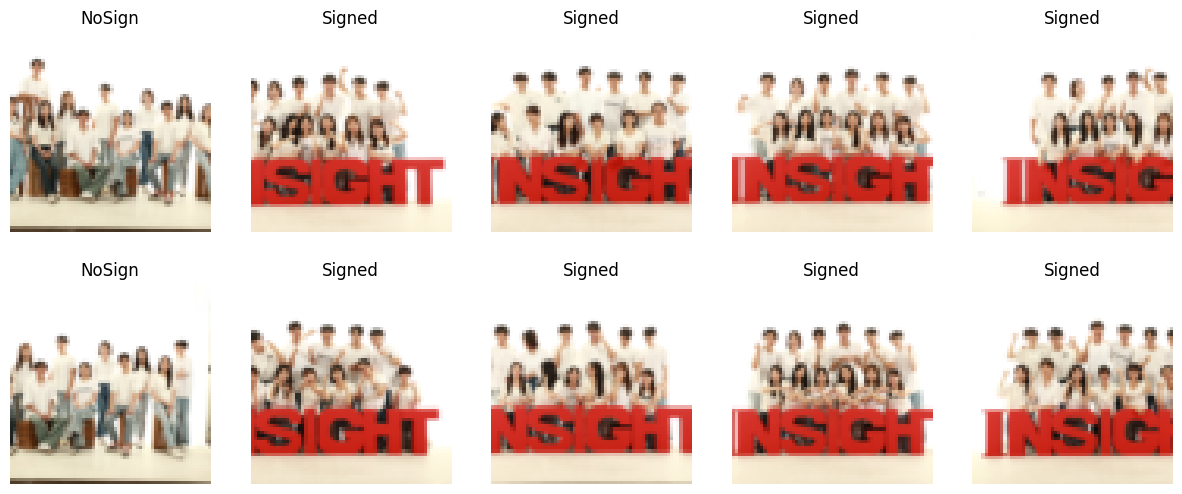

In [13]:
# show image examples

dls.train.show_batch(max_n=10, nrows=2)  # train dataset의 예시 batch 출력 -> 이미지 크기 동일!

# 3. Train CNN model

In [14]:
learn = vision_learner(dls, resnet18, metrics=accuracy).to_fp16() # resnet 18, 34, 50, 101, 152
learn.fine_tune(1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 34.3MB/s]
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,accuracy,time
0,1.879390,0.385043,0.800000,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.903944,0.084603,1.000000,00:02


## 3.1 Confusion matrix and images with top losses

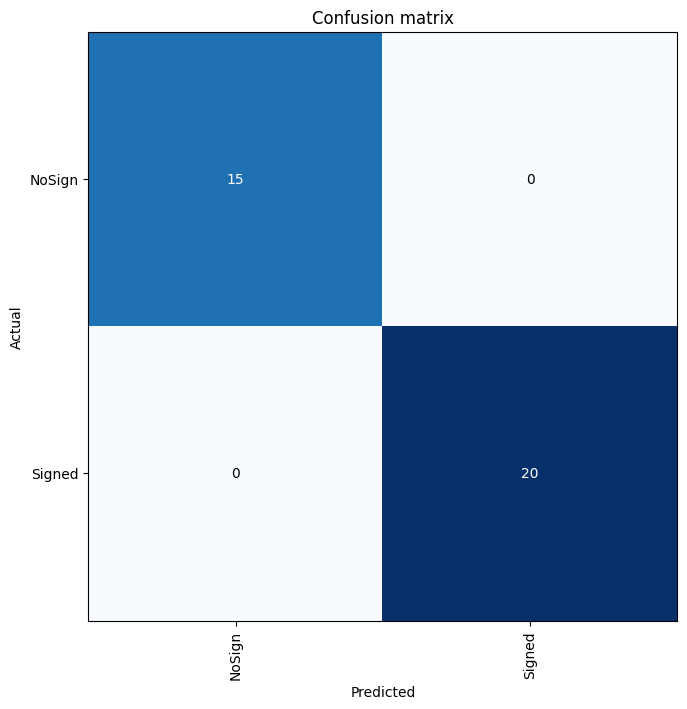

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(7,7))  # validation set의 혼동행렬, grass 와 foreset를 모델이 헷갈려 하는구나!
# 다른 사람들과 다른 이유: 처음 받는 이미지의 batch가 다를 수 있음, 처음 설정된 weight가 랜덤하게 다를 수 있음

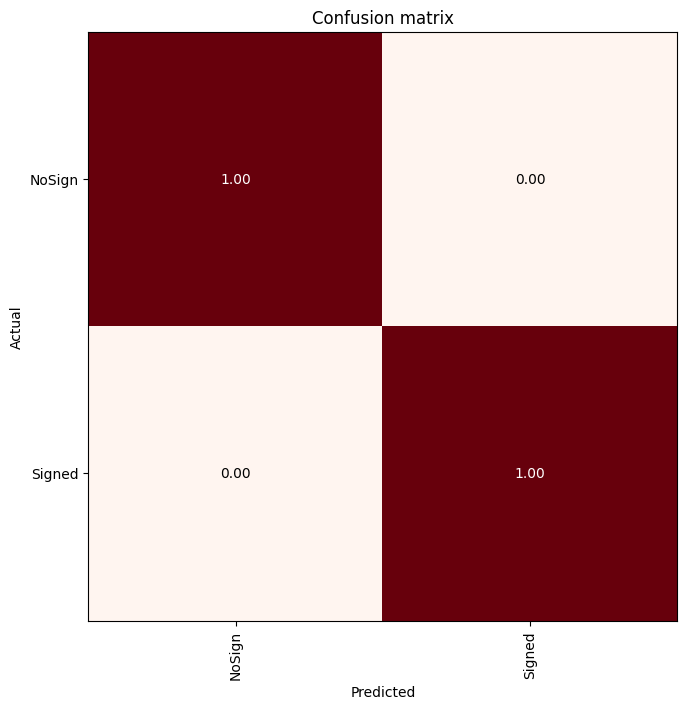

In [16]:
interp.plot_confusion_matrix(normalize=True, cmap='Reds', figsize=(7,7))  # normalized confusion matrix

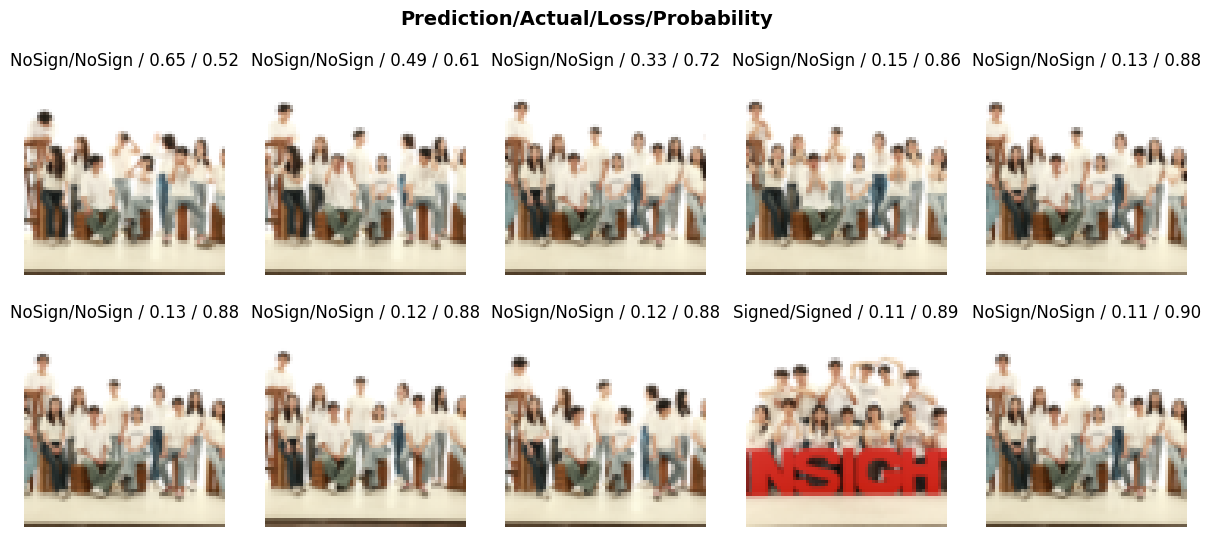

In [17]:
interp.plot_top_losses(10, nrows=2)

# 4. Tuning the model

## 4.1. More epochs

In [18]:
# 3 epochs instead of 1 epoch

learn = vision_learner(dls, resnet18, metrics=accuracy).to_fp16() # resnet 18, 34, 50, 101, 152
learn.fine_tune(3)

epoch,train_loss,valid_loss,accuracy,time
0,1.131168,0.447597,0.714286,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.643166,0.037492,1.000000,00:03
1,0.400967,0.001665,1.000000,00:04
2,0.269800,0.000695,1.000000,00:03


## 4.2 Deeper network

In [19]:
# Use Resnet50 instead of Resnet18

learn = vision_learner(dls, resnet50, metrics=accuracy).to_fp16() # resnet 18, 34, 50, 101, 152
learn.fine_tune(1)
# 신경망이 복잡할수록 epoch를 많이 돌려야 함

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 191MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,1.359529,0.698710,0.714286,00:04


epoch,train_loss,valid_loss,accuracy,time
0,1.499110,0.676556,0.657143,00:06


## 4.3 Image augmentation

In [20]:
# add augmentation option: batch_tfms=aug_transforms(mult=2)

my_augmented_dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=valid_set_share, seed=my_random_seed),
    get_y=parent_label,
    item_tfms=Resize(image_size),
    batch_tfms=aug_transforms(mult=2)) # 이미지를 돌리고 늘리고,,, 해서 이미지 수를 늘림

my_augmented_dls = my_augmented_dblock.dataloaders(path)

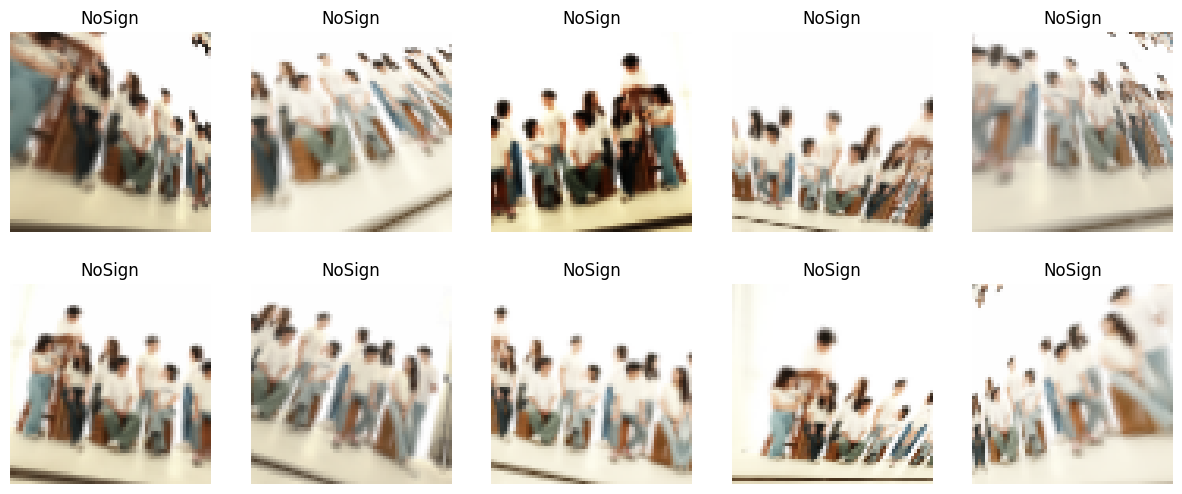

In [21]:
# show image examples
my_augmented_dls.train.show_batch(max_n=10, nrows=2, unique=True)

In [22]:
learn = vision_learner(my_augmented_dls, resnet18, metrics=accuracy).to_fp16() # resnet 18, 34, 50, 101, 152
learn.fine_tune(1)

epoch,train_loss,valid_loss,accuracy,time
0,1.374754,0.530725,0.742857,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.743819,0.090957,0.971429,00:03


## 4.4 Image augmentation + Resnet50 + more epochs

In [23]:
learn = vision_learner(my_augmented_dls, resnet50, metrics=accuracy).to_fp16() # resnet 18, 34, 50, 101, 152
learn.fine_tune(10)  # tuning option도 퀴즈에서 지정해줄 수 있음

# 10번 돌리는 게 맞는 건지를 보려면 -> valid_loss를 관찰

epoch,train_loss,valid_loss,accuracy,time
0,1.286539,0.559188,0.600000,00:04


epoch,train_loss,valid_loss,accuracy,time
0,1.229816,0.597355,0.571429,00:03
1,1.096390,0.253007,0.971429,00:03
2,0.987930,0.029593,1.000000,00:03
3,0.879214,0.002235,1.000000,00:05
4,0.733232,0.000770,1.000000,00:03
5,0.637776,0.000357,1.000000,00:03
6,0.554873,0.001102,1.000000,00:05
7,0.496807,0.002082,1.000000,00:03
8,0.452157,0.002508,1.000000,00:03
9,0.419856,0.003552,1.000000,00:03


# 5. Plot loss

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

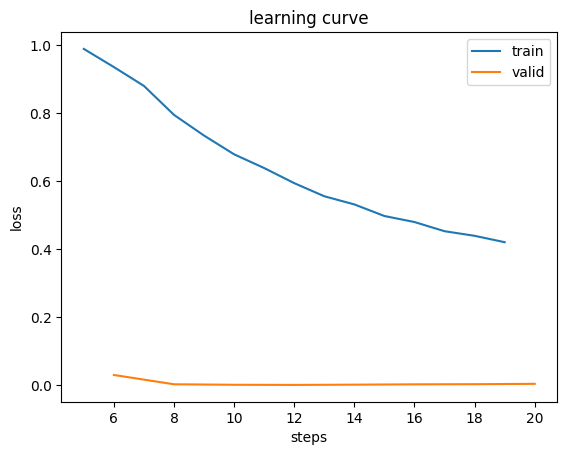

In [24]:
learn.recorder.plot_loss(with_valid=True)

# 6. Early stopping

In [ ]:
learn = vision_learner(my_augmented_dls, resnet50, metrics=accuracy).to_fp16() # resnet 18, 34, 50, 101, 152
learn.path = Path('./')

learn.fine_tune(50, cbs=[EarlyStoppingCallback(monitor='accuracy', patience=5),SaveModelCallback(monitor='accuracy')])

# accuracy 은 같아도 25->26 train_loss가 줄어듦 = 아마도 데이터셋을 더 잘 외운 효과

epoch,train_loss,valid_loss,accuracy,time
0,1.977302,0.638499,0.803333,00:03


Better model found at epoch 0 with accuracy value: 0.8033333420753479.


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy,time
0,0.983458,0.523303,0.826667,00:04
1,0.919750,0.419089,0.856667,00:03
2,0.822206,0.336954,0.883333,00:03
3,0.774823,0.303998,0.896667,00:04
4,0.695448,0.273279,0.913333,00:04
5,0.624401,0.241973,0.906667,00:04
6,0.616949,0.209440,0.926667,00:05
7,0.568131,0.171672,0.930000,00:03
8,0.515286,0.188147,0.923333,00:03
9,0.481097,0.173085,0.916667,00:05


Better model found at epoch 0 with accuracy value: 0.8266666531562805.
Better model found at epoch 1 with accuracy value: 0.8566666841506958.
Better model found at epoch 2 with accuracy value: 0.8833333253860474.
Better model found at epoch 3 with accuracy value: 0.8966666460037231.
Better model found at epoch 4 with accuracy value: 0.9133333563804626.
Better model found at epoch 6 with accuracy value: 0.9266666769981384.
Better model found at epoch 7 with accuracy value: 0.9300000071525574.
Better model found at epoch 11 with accuracy value: 0.9399999976158142.
Better model found at epoch 12 with accuracy value: 0.9566666483879089.
Better model found at epoch 16 with accuracy value: 0.9666666388511658.
Better model found at epoch 17 with accuracy value: 0.9700000286102295.
Better model found at epoch 19 with accuracy value: 0.9733333587646484.
Better model found at epoch 22 with accuracy value: 0.9766666889190674.
Better model found at epoch 23 with accuracy value: 0.9800000190734863.

In [ ]:
learn.validate()

(#2) [0.03461146727204323,0.9900000095367432]

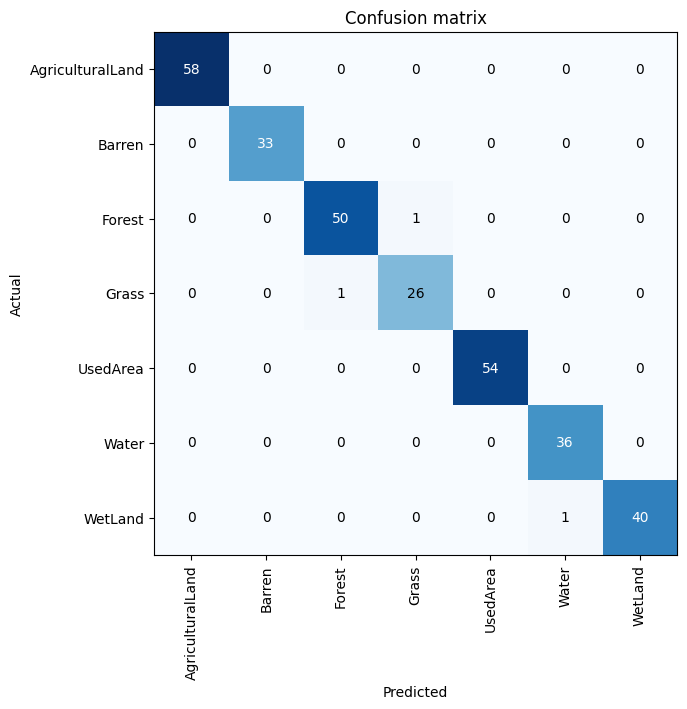

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(7,7))

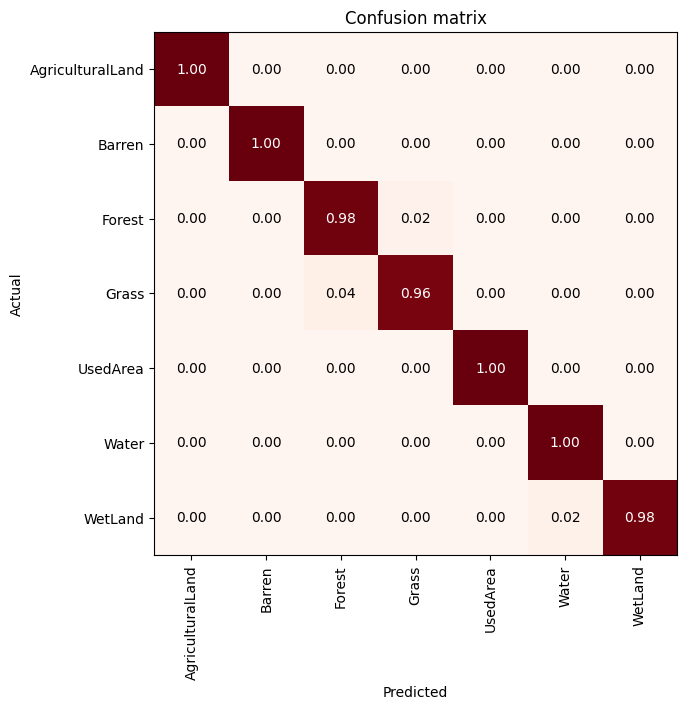

In [ ]:
interp.plot_confusion_matrix(normalize=True, cmap='Reds', figsize=(7,7)) # normalize=True parameter 추가

# 7. Save your model

In [25]:
# export your model
learn.export()

In [26]:
!ls

export.pkl  insight_img.zip  lclu  new_folder  sample_data


In [27]:
# download the file to your local compupter
files.download('./export.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>